## Maximum Likelihood Multinomial Model

In [1]:
import scipy.io as sio

data = sio.loadmat('kos_doc_data.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Feb 17 18:20:08 2012',
 '__version__': '1.0',
 '__globals__': [],
 'A': array([[   1,    2,    1],
        [   1,   15,    1],
        [   1,   28,    1],
        ...,
        [2000, 6689,    1],
        [2000, 6761,    1],
        [2000, 6798,    2]], dtype=uint16),
 'B': array([[2001,   69,    3],
        [2001,   75,    1],
        [2001,   76,    1],
        ...,
        [3430, 6738,    1],
        [3430, 6760,    1],
        [3430, 6767,    1]], dtype=uint16),
 'V': array([[array(['aarp'], dtype='<U4')],
        [array(['abandon'], dtype='<U7')],
        [array(['abandoned'], dtype='<U9')],
        ...,
        [array(['zogbys'], dtype='<U6')],
        [array(['zone'], dtype='<U4')],
        [array(['zones'], dtype='<U5')]], dtype=object)}

In [2]:
A = data['A']   # doc ID, vocab ID, vocab count
B = data['B']
V = data['V']   # names of all the vocabs
print(A.shape)
print(V.shape)
print(V[:2])

(205211, 3)
(6906, 1)
[[array(['aarp'], dtype='<U4')]
 [array(['abandon'], dtype='<U7')]]


In [3]:
A

array([[   1,    2,    1],
       [   1,   15,    1],
       [   1,   28,    1],
       ...,
       [2000, 6689,    1],
       [2000, 6761,    1],
       [2000, 6798,    2]], dtype=uint16)

In [4]:
print('Maximum vocab counts in `A` =', max(A[:,2]))

Maximum vocab counts in `A` = 29


### Import data into pandas Dataframe for clearer demo.

In [5]:
# import pandas as pd

# pd.set_option('display.max_rows', 6)

# df_docsA = pd.DataFrame()

# df_docsA['document ID'] = A[:,0]
# df_docsA['vocab ID'] = A[:,1]
# df_docsA['vocab counts'] = A[:,2]

# df_docsA

In [6]:
# df_docsB = pd.DataFrame()

# df_docsB['document ID'] = B[:,0]
# df_docsB['vocab ID'] = B[:,1]
# df_docsB['vocab counts'] = B[:,2]

# df_docsB

### Explore vocabs in `A` and `B`

In [7]:
import numpy as np

train_vocab_IDs = np.unique(A[:, 1])
print(train_vocab_IDs)
train_vocab_IDs.shape

[   1    2    3 ... 6904 6905 6906]


(6892,)

In [8]:
test_vocab_IDs = np.unique(B[:,1])
print(test_vocab_IDs)
test_vocab_IDs.shape

[   1    2    3 ... 6904 6905 6906]


(6870,)

^ vocabs ID for both `A` and `B` go up to 6906. However, there are only 6892 unique IDs in `A`, and even less no (6870 unique IDs) in `B`.

### Discover difference in vocab set b/w `A` and `B`

In [9]:
print('The following are the (IDs of) vocabs which exists in `A` but not in `B`:\n')
vocabIDs_inA_notB = np.setdiff1d(train_vocab_IDs, test_vocab_IDs)

print(vocabIDs_inA_notB)
print(vocabIDs_inA_notB.shape[0], 'of them.')

vocabNames_inA_notB = [ name[0][0] for name in V[vocabIDs_inA_notB] ]
print('\n',vocabNames_inA_notB)

The following are the (IDs of) vocabs which exists in `A` but not in `B`:

[ 259  491  633  968 1018 1213 1592 1596 1855 1863 1917 2045 2159 2441
 2637 2688 2696 2709 2740 3158 3571 3628 3824 4245 4385 4487 4911 5324
 5396 5455 5488 6178 6202 6302 6737 6850]
36 of them.

 ['andor', 'ayatollah', 'bit', 'census', 'charts', 'communities', 'dec', 'december', 'dncs', 'documented', 'drama', 'email', 'ethical', 'flash', 'gen', 'god', 'goodness', 'gotta', 'gray', 'ineffective', 'lend', 'lindsey', 'matsunaka', 'oconnor', 'pac', 'penn', 'qaeda', 'robust', 'rusty', 'scan', 'scope', 'taste', 'televised', 'tiny', 'website', 'wouldnt']


In [10]:
# print('Vocabs only in training set but not in test set:')
# # vocabNames_inA_notB
# print('\n',vocabNames_inA_notB)

In [11]:
print('The following are the (IDs of) vocabs which exists in `B` but not in `A`:\n')

vocabIDs_inB_notA = np.setdiff1d(test_vocab_IDs, train_vocab_IDs)
print(vocabIDs_inB_notA)
print(vocabIDs_inB_notA.shape[0], 'of them.')

vocabNames_inB_notA = [ name[0][0] for name in V[vocabIDs_inB_notA] ]
print('\n', vocabNames_inB_notA)

The following are the (IDs of) vocabs which exists in `B` but not in `A`:

[ 196  234  249  816  949 1584 2666 3607 3842 5416 5480 5811 5839 5919]
14 of them.

 ['ali', 'amendment', 'ample', 'bulk', 'cattle', 'death', 'giant', 'lieberman', 'mcentee', 'sailor', 'schwarzenegger', 'specializes', 'split', 'stem']


In [12]:
# print('Vocabs only in test set but not in training set:')
# print('\n',vocabNames_inB_notA)

### Compute maximum likelihood of word probs from `A`.

In [13]:
# Compute maximum likelihood beta_ = [beta_1, ..., beta_M].T
# Each scalar beta_m simply equals "count of vocab m across all docs in A" / "total counts of all vocab across all docs."

beta_IDorder = np.zeros(V.shape[0])

for vocab_m in train_vocab_IDs:   # Start from 1 to 6906, with missing numbers in between.
        
    vocab_m_indices = np.where(A[:,1] == vocab_m)

    c_m = np.sum(A[vocab_m_indices, 2].T)
    
    beta_IDorder[vocab_m - 1] = c_m   # "count of vocab m across all docs in A"

print(np.sum(beta_IDorder))
    
beta_IDorder = beta_IDorder/np.sum(beta_IDorder)   # Divide every c_m by "total counts of all vocab across all docs."

# Sanity check: Summing all beta_m should give unity. [Test passed]
# np.sum(beta_IDorder)

beta_IDorder    # shape = (6906,)

271898.0


array([1.47113991e-05, 6.25234463e-05, 4.78120472e-05, ...,
       6.25234463e-05, 1.17691193e-04, 2.20670987e-05])

### Show the 20 largest probabilities $\beta_m$ in a histogram.

i_ascending_order = [ 815 5918 3606 ... 4195 3419  840]
beta_ascending_order = [0.         0.         0.         ... 0.00841124 0.00967642 0.0140972 ]


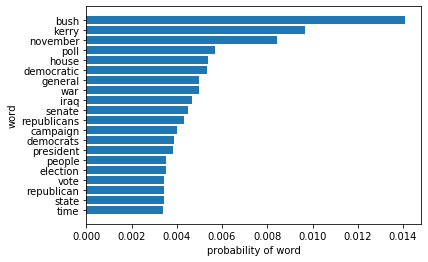

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

i_ascending_order = np.argsort(beta_IDorder)   # minus sign gives descending order.
print('i_ascending_order =', i_ascending_order)

beta_ascending_order = beta_IDorder[i_ascending_order]
print('beta_ascending_order =', beta_ascending_order)

# Sanity Check: There should be 6892 out of 6906 vocabs having non-zero probabilities, 
# because there were only 6892 unique vocabs in `A`.  [Test passed.]
# np.count_nonzero(beta_ascending_order)


# Plot histogram for num=20 largest beta_m.
num = 20

x_pos = np.linspace(1, num, num)    # 'endpoint=True' by default
plt.barh(x_pos, beta_ascending_order[-num:])

vocab_names = [ name[0][0] for name in V[i_ascending_order[-num:]] ]

plt.yticks(x_pos, vocab_names)

plt.xlabel('probability of word')
plt.ylabel('word')

plt.show()

np.save('results/a/ML_beta.npy', beta_ascending_order)
np.save('results/a/ML_vocab_names.npy', [ name[0][0] for name in V[i_ascending_order] ])